MODULE 4

In this module we are gonna try to develop a ML model by using non-linear regression, to find the best one:
- Baseline (global popularity)
- Linear Regression
- Decision tree
- Random Forest
- Descent Gradient

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [4]:
df = pd.read_csv('../../data/feature_frame.csv')

In [3]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [5]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
feature_cols = {col for col in df if col not in info_cols + [label_col]}

categorical_cols = ['product_type', 'vendor']
binary_cols= ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = {col for col in feature_cols if col not in categorical_cols + binary_cols}

In [6]:
# get those orders with more than 5 products -> df_2

items_per_order = df.groupby('order_id').outcome.sum()
big_orders = items_per_order[items_per_order > 5].index

df_2 = df[df['order_id'].isin(big_orders)]

In [7]:
df_2['order_date'] = pd.to_datetime(df_2['order_date'])

/tmp/ipykernel_2374/1778527225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['order_date'] = pd.to_datetime(df_2['order_date'])


- Now, the train, val, test. Cronologychal order is important. For this task, we are sorting orders by date and then splitting it 80/20/20

In [8]:
df_2.sort_values(by='order_date')

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
447124,33667196420228,cleaningaccessories,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,32.0,30.380568,30.0,35.0,29.001400
447125,33667196420228,cleaningaccessories,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,32.0,30.380568,30.0,35.0,29.001400
2168673,34086451019908,healthcarevitamins,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,1.0,0.0,...,0.0,0.0,0.0,2.0,33.0,32.0,26.956172,30.0,34.0,27.451392
2168672,34086451019908,healthcarevitamins,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,32.0,26.956172,30.0,34.0,27.451392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509709,34276571316356,ricepastapulses,3643241300100,3864791220356,2021-03-03 12:56:04,2021-03-03,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,31.0,28.754468,30.0,30.0,24.276180
509712,34276571316356,ricepastapulses,3643254800516,3893722808452,2021-03-03 13:19:28,2021-03-03,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,31.0,28.754468,30.0,30.0,24.276180
509714,34276571316356,ricepastapulses,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03,7,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,31.0,28.754468,58.0,30.0,24.276180
2391661,34368924647556,pickledfoodolives,3643294515332,3906490826884,2021-03-03 14:30:30,2021-03-03,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,28.0,14.472924,36.0,30.0,25.477284


In [9]:
n_total = len(df_2)
n_train = int(0.6 * n_total)
n_val = int (0.2 * n_total)

train_df = df_2[:n_train]
val_df = df_2[n_train:n_train + n_val]
test_df = df_2[n_train + n_val:]

In [10]:
predictive_cols = binary_cols + list(numerical_cols)

In [11]:
X_train = train_df[predictive_cols]
y_train = train_df[label_col]

X_val = val_df[predictive_cols]
y_val = val_df[label_col]

X_test = test_df[predictive_cols]
y_test = test_df[label_col]

-- Baseline (global popularity)

In [21]:
y_train_base = X_train['global_popularity']
y_val_base = X_val['global_popularity']

y_train_proba_base = y_train_base
y_val_proba_base = y_val_base

fpr_train_base, tpr_train_base, _ = roc_curve(y_train, y_train_proba_base)
roc_auc_train_base = auc(fpr_train_base, tpr_train_base)

fpr_val_base, tpr_val_base, _ = roc_curve(y_val, y_val_proba_base)
roc_auc_val_base = auc(fpr_val_base, tpr_val_base)

precision_train_base, recall_train_base, _ = precision_recall_curve(y_train, y_train_proba_base)
pr_auc_train_base = auc(recall_train_base, precision_train_base)

precision_val_base, recall_val_base, _ = precision_recall_curve(y_val, y_val_proba_base)
pr_auc_val_base = auc(recall_val_base, precision_val_base)

# Imprimir los resultados
print(f"Baseline Results:")
print(f"T-ROC-AUC = {roc_auc_train_base:.4f}, V-ROC-AUC = {roc_auc_val_base:.4f}")
print(f"T-PR-AUC = {pr_auc_train_base:.4f}, V-PR-AUC = {pr_auc_val_base:.4f}")

Baseline Results:
T-ROC-AUC = 0.7441, V-ROC-AUC = 0.7411
T-PR-AUC = 0.0686, V-PR-AUC = 0.0301


1. DECISION TREE

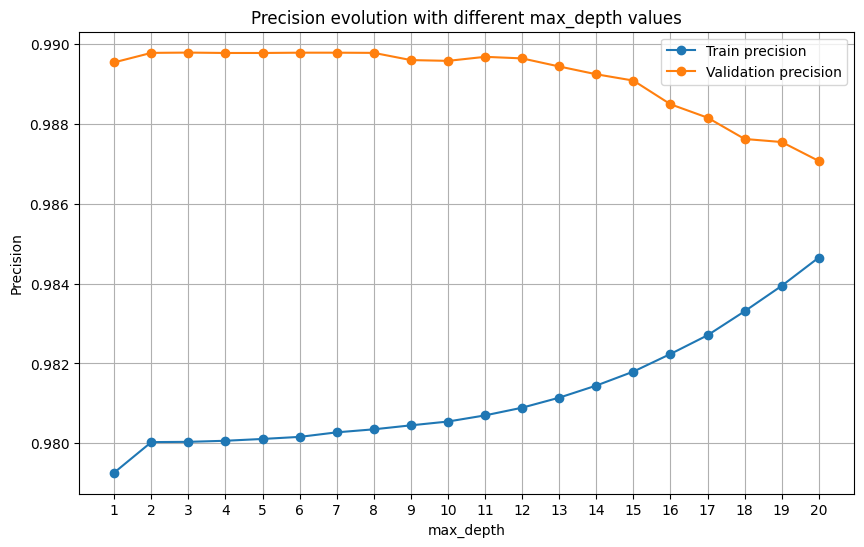

In [12]:
max_depth_values = np.arange(1, 21)
train_scores = []
val_scores = []

for depth in max_depth_values:
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=42) # no standarization needed in trees

    tree_clf.fit(X_train, y_train)

    train_scores.append(tree_clf.score(X_train, y_train))
    val_scores.append(tree_clf.score(X_val, y_val))


# Graph result
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_scores, label='Train precision', marker='o')
plt.plot(max_depth_values, val_scores, label='Validation precision', marker='o')
plt.title('Precision evolution with different max_depth values')
plt.xlabel('max_depth')
plt.ylabel('Precision')
plt.xticks(max_depth_values)
plt.legend()
plt.grid()
plt.show()

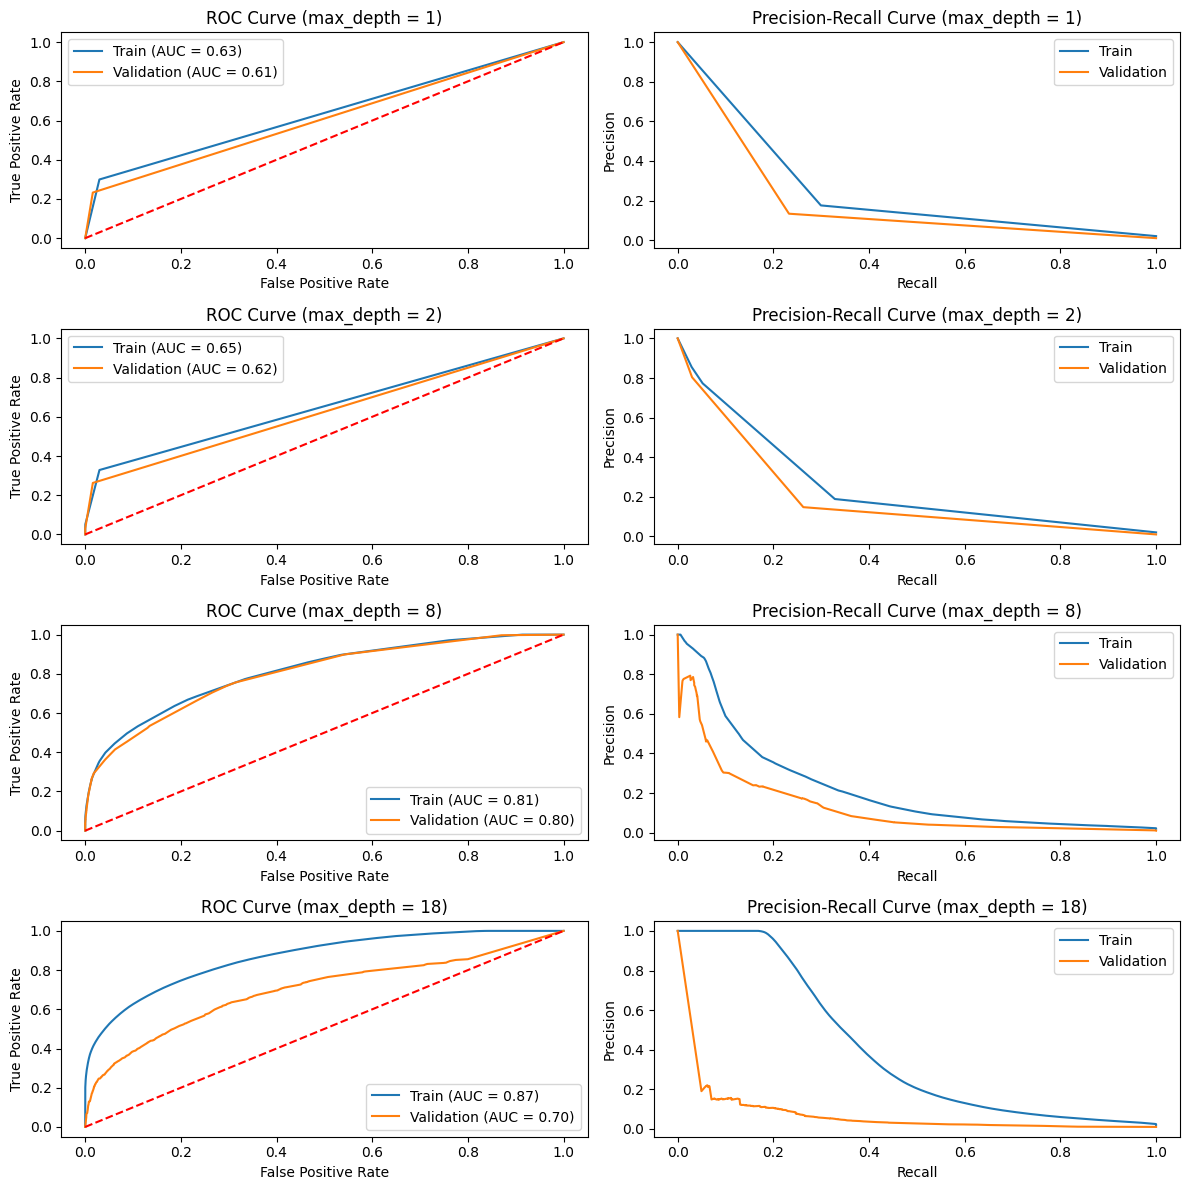

In [15]:
max_depth_values = [1, 2, 8, 18]

plt.figure(figsize=(12, 12))

for i, max_depth in enumerate(max_depth_values, start=1):
    tree_clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

    tree_clf.fit(X_train, y_train)

    y_train_proba = tree_clf.predict_proba(X_train)[:, 1]
    y_val_proba = tree_clf.predict_proba(X_val)[:, 1]

    # ROC CURVES
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
    roc_auc_val = auc(fpr_val, tpr_val)

    # PREC-RECALL CURVES
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)

    # ROC
    plt.subplot(4, 2, 2*i-1)
    plt.plot(fpr_train, tpr_train, label='Train (AUC = {:.2f})'.format(roc_auc_train))
    plt.plot(fpr_val, tpr_val, label='Validation (AUC = {:.2f})'.format(roc_auc_val))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
    plt.title(f'ROC Curve (max_depth = {max_depth})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    # Graficar Precision-Recall
    plt.subplot(4, 2, 2*i)  # Graficar en la segunda y cuarta posición
    plt.plot(recall_train, precision_train, label='Train')
    plt.plot(recall_val, precision_val, label='Validation')
    plt.title(f'Precision-Recall Curve (max_depth = {max_depth})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

plt.tight_layout()
plt.show()

In [14]:
max_depth_values = [1, 2, 8, 18]

for max_depth in max_depth_values:
    
    tree_clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    tree_clf.fit(X_train, y_train)

    y_train_proba = tree_clf.predict_proba(X_train)[:, 1]
    y_val_proba = tree_clf.predict_proba(X_val)[:, 1]

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
    roc_auc_val = auc(fpr_val, tpr_val)
    
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
    pr_auc_train = auc(recall_train, precision_train)
    
    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)
    pr_auc_val = auc(recall_val, precision_val)

    print(f"Results for max_depth = {max_depth} ----> "
        f"T-ROC-AUC = {roc_auc_train:.4f}, V-ROC-AUC = {roc_auc_val:.4f}, "
        f"T-PR-AUC = {pr_auc_train:.4f}, V-PR-AUC = {pr_auc_val:.4f}")

Results for max_depth = 1 ----> T-ROC-AUC = 0.6348, V-ROC-AUC = 0.6084, T-PR-AUC = 0.2448, V-PR-AUC = 0.1873
Results for max_depth = 2 ----> T-ROC-AUC = 0.6501, V-ROC-AUC = 0.6236, T-PR-AUC = 0.2492, V-PR-AUC = 0.1962
Results for max_depth = 8 ----> T-ROC-AUC = 0.8095, V-ROC-AUC = 0.7997, T-PR-AUC = 0.2209, V-PR-AUC = 0.1285
Results for max_depth = 18 ----> T-ROC-AUC = 0.8658, V-ROC-AUC = 0.6983, T-PR-AUC = 0.3988, V-PR-AUC = 0.0751


In this case, with max depth = 8 we obtain a similar result than linear regression.

2. RANDOM FOREST

First, let's implement de random forest classifier to see the precision of the model if we switch into different max_depth values, and then for many tree_count values.

In [19]:
max_depth_values = [2, 8, 12]
n_estimators_values = [10, 50, 100]

for max_depth in max_depth_values:
    for n_estimators in n_estimators_values:
        
        rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf_clf.fit(X_train, y_train)

        y_train_proba = rf_clf.predict_proba(X_train)[:, 1]
        y_val_proba = rf_clf.predict_proba(X_val)[:, 1]

        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
        roc_auc_train = auc(fpr_train, tpr_train)
        
        fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
        roc_auc_val = auc(fpr_val, tpr_val)

        precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
        pr_auc_train = auc(recall_train, precision_train)
        
        precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)
        pr_auc_val = auc(recall_val, precision_val)

        print(f"Results for max_depth = {max_depth}, n_estimators = {n_estimators} ---> "
            f"T-ROC-AUC = {roc_auc_train:.4f}, V-ROC-AUC = {roc_auc_val:.4f}, "
            f"T-PR-AUC = {pr_auc_train:.4f}, V-PR-AUC = {pr_auc_val:.4f}")

Results for max_depth = 2, n_estimators = 10 ---> T-ROC-AUC = 0.7615, V-ROC-AUC = 0.7018, T-PR-AUC = 0.1751, V-PR-AUC = 0.1163
Results for max_depth = 2, n_estimators = 50 ---> T-ROC-AUC = 0.7757, V-ROC-AUC = 0.7314, T-PR-AUC = 0.1809, V-PR-AUC = 0.1092
Results for max_depth = 2, n_estimators = 100 ---> T-ROC-AUC = 0.7819, V-ROC-AUC = 0.7459, T-PR-AUC = 0.1818, V-PR-AUC = 0.1124
Results for max_depth = 8, n_estimators = 10 ---> T-ROC-AUC = 0.8053, V-ROC-AUC = 0.7750, T-PR-AUC = 0.2248, V-PR-AUC = 0.1363
Results for max_depth = 8, n_estimators = 50 ---> T-ROC-AUC = 0.8107, V-ROC-AUC = 0.7927, T-PR-AUC = 0.2289, V-PR-AUC = 0.1443
Results for max_depth = 8, n_estimators = 100 ---> T-ROC-AUC = 0.8118, V-ROC-AUC = 0.7942, T-PR-AUC = 0.2285, V-PR-AUC = 0.1439
Results for max_depth = 12, n_estimators = 10 ---> T-ROC-AUC = 0.8241, V-ROC-AUC = 0.7855, T-PR-AUC = 0.2748, V-PR-AUC = 0.1351
Results for max_depth = 12, n_estimators = 50 ---> T-ROC-AUC = 0.8298, V-ROC-AUC = 0.7922, T-PR-AUC = 0.2834

As results are so similar to decision trees, at this point we are choosing decision tree as the best model so far. Now, we are gonna try gradient 

3. Gradient Boosting Tree

APUNTES: UTILIZAR N_ITER_NO_CHANGE

In [ ]:
learning_rates = [1, 0.05]
n_estimators_list = [10, 50, 100]

results = {lr: [] for lr in learning_rates}

for learning_rate in learning_rates:
    for n_estimators in n_estimators_list:
        gb_clf = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=8,
            n_iter_no_change=10,
            random_state=42
        )
        
        gb_clf.fit(X_train, y_train)

        y_train_pred = gb_clf.predict(X_train)
        y_val_pred = gb_clf.predict(X_val)

        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)

        results[learning_rate].append((n_estimators, train_accuracy, val_accuracy))

plt.figure(figsize=(10, 6))

for learning_rate, accuracies in results.items():
    n_estimators = [x[0] for x in accuracies]
    train_acc = [x[1] for x in accuracies]
    val_acc = [x[2] for x in accuracies]
    
    plt.plot(n_estimators, train_acc, marker='o', label=f'Train (learning rate = {learning_rate})')
    plt.plot(n_estimators, val_acc, marker='o', label=f'Validation (learning rate = {learning_rate})', linestyle='--')

plt.title('GB precision vs Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Precision')
plt.xticks(n_estimators_list)
plt.ylim(0, 1) 
plt.legend()
plt.grid()
plt.show()